In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def reset_params():
    params = {}
    params['a'] = 270 #Hz/nA
    params['b'] = 108 #Hz
    params['d'] = 0.154 #s
    params['gamma'] = 0.641
    params['tau_s'] = 100/1000 #s (100 ms)
    params['gE'] = 0.2609 #nA
    params['gI'] = 0.0497 #nA
    params['gext'] = 0.00052 #nA
    params['I0'] = 0.3255 #nA
    params['tau_0'] = 2/1000 #s (2 ms)
    params['sig'] = 0.02 #nA
    params['Tmax'] = 3 #s
    params['del_t'] = 0.001 #s (1 ms)
    params['ntrials'] = 10
    params['len_T'] = int(params['Tmax']/params['del_t'])
    return params
params = reset_params()

fdict = {}
fdict['stitle'] = 20
fdict['title'] = 16
fdict['axes'] = 14

In [10]:
def firing_rate(I_val, params):
    a = params['a']
    b = params['b']
    d = params['d']
    r = (a*I_val-b)/(1-np.exp(-d*(a*I_val-b)))
    return r

def background_input():
    tau_0 = params['tau_0']
    I0 = params['I0']
    sig = params['sig']
    del_t = params['del_t']
    len_T = params['len_T']
    Ib = np.zeros((2, len_T))
    for t in range(len_T-1):
        for ii in range(2):
            Ib[ii, t+1] = Ib[ii, t] + ((del_t/tau_0) * (-(Ib[ii, t] - I0) )) + (np.sqrt(del_t/tau_0)*sig*np.random.normal())
    return Ib

def synaptic_dynamics(mu, params):
    gamma = params['gamma']
    tau_s = params['tau_s']
    d = params['d']
    gE = params['gE']
    gI = params['gI']
    gext = params['gext']
    del_t = params['del_t']
    ntrials = params['ntrials']
    len_T = params['len_T']
    s = 0.1 * np.ones((2,len_T, ntrials))
    r = np.zeros((2,len_T, ntrials))
    for ff in range(ntrials):
        
        Ib = background_input()
        for t in range(len_T - 1):
            I = np.zeros(2,)
            I[0] = gE * s[0, t, ff] - gI * s[1, t, ff] + Ib[0, t] + gext * mu[0, t]
            I[1] = gE * s[1, t, ff] - gI * s[0, t, ff] + Ib[1, t] + gext * mu[1, t]
            # if gE_stable == 'no':
            #     if t >= decay_start:
            #         gE -= 0.01
            for ii in range(len(I)):
                r[ii, t, ff] = firing_rate(I[ii], params)
                del_s = (r[ii, t, ff] * gamma * (1-s[ii, t, ff])) - (s[ii, t, ff]/tau_s)
                s[ii, t+1, ff] = s[ii, t, ff] + del_t * del_s
    return s,r

def plot_fr_dynamics(r, s, stim, t_stim, qnum, params, fdict):
    if qnum == '1a':
        tname = 'Resting state'
    elif qnum == '1b1':
        tname = 'Stimulus 1 on'
    elif qnum == '1b2':
        tname = 'Stimulus 2 on'
    elif qnum == '1b3':
        tname = 'Back to resting state'
    elif qnum == '1d':
        tname = 'Effect of distractor'
    elif qnum == '1e':
        tname = [f'gE = {round(params["gE"], 3)}']
    elif qnum == '2':
        tname = 'Coin-tossing simulation for 10 trials'
    Tmax = params['Tmax']
    del_t = params['del_t']
    time = np.arange(0, Tmax, params['del_t'])
    ticker_range = np.arange(0, Tmax+0.1, 0.5)
    t_stim = np.asarray(t_stim)

    fig, axs = plt.subplots(1, 3, figsize = (20, 6))
    axs[0].plot(time, stim[0, :], 'k')
    axs[0].plot(time, stim[1, :], 'r')
    axs[0].set_xlabel('Time (s)', fontsize = fdict['axes'])
    axs[0].set_ylabel('Stimulus', fontsize = fdict['axes'])
    axs[0].set_xticks(ticker_range)
    axs[0].set_title('Input current', fontsize = fdict['title'])

    axs[1].plot(time[:-1], s[0, :-1, :], 'k')
    axs[1].plot(time[:-1], s[1, :-1, :], 'r')
    for mm in range(t_stim.shape[0]):
        axs[1].axvline(x = t_stim[mm, 0]*del_t, color='m', linestyle = '--')
        axs[1].axvline(x = t_stim[mm, 1]*del_t, color='m', linestyle = '--')
    axs[1].set_xlabel('Time (s)', fontsize = fdict['axes'])
    axs[1].set_ylabel('Synaptic drive', fontsize = fdict['axes'])
    axs[1].set_xticks(ticker_range)
    axs[1].set_ylim([0, 1])
    axs[1].set_title('s(t)', fontsize = fdict['title'])

    axs[2].plot(time[:-1], r[0, :-1, :], 'k')
    axs[2].plot(time[:-1], r[1, :-1, :], 'r')
    for mm in range(t_stim.shape[0]):
        axs[2].axvline(x = t_stim[mm, 0]*del_t, color='m', linestyle = '--')
        axs[2].axvline(x = t_stim[mm, 1]*del_t, color='m', linestyle = '--')
    axs[2].set_xlabel('Time (s)', fontsize = fdict['axes'])
    axs[2].set_ylabel('Firing rate (Hz)', fontsize = fdict['axes'])
    axs[2].set_xticks(ticker_range)
    axs[2].set_title('r(t)', fontsize = fdict['title'])
    plt.suptitle(tname, fontsize = fdict['stitle'])
    plt.show()
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 6))
    p1 = axs[0].scatter(s[0, :-1, 0], s[1, :-1, 0], s = 5, c = time[:-1], cmap = 'plasma')
    axs[0].set_xlabel('S1', fontsize = fdict['axes'])
    axs[0].set_ylabel('S2', fontsize = fdict['axes'])
    axs[0].set_xlim([0, 1])
    axs[0].set_ylim([0, 1])
    axs[0].set_title('State space s(t)', fontsize = fdict['title'])

    max_r = np.ceil(np.max(r))
    p2 = axs[1].scatter(r[0, :-1, 0], r[1, :-1, 0], s = 5, c = time[:-1], cmap = 'plasma')
    axs[1].set_xlabel('Firing rate 1 (Hz)', fontsize = fdict['axes'])
    axs[1].set_ylabel('Firing rate 2 (Hz)', fontsize = fdict['axes'])
    axs[1].set_xlim([0, max_r])
    axs[1].set_ylim([0, max_r])
    axs[1].set_title('State space r(t)', fontsize = fdict['title'])
    cbar = fig.colorbar(p2)
    plt.show()

#### Q1. Consider first a delayed response task.
#### (a). First, run the model simulation for 500-1000 msec without stimulus ($\mu_1 = \mu_2 = 0 $). With the initial condition $s_1 = s_2 = 0 $, show that the system is at a resting state, and determine the firing rate at that state.
#### (b). After the system has settled in the resting state, show a stimulus ($\mu_1 = 35, \mu_2 = 0 $) for a brief period of time (say 300 msec), followed by a delay 'memory period' (say for 3 sec). Do you see a 'persistent activity' state, if so with what $r_1 $ and $r_2 $ values in Hz? Repeat the simulation with $\mu_1 = 0, \mu_2 = 35 $, do you observe another memory state and what are the corresponding $r_1 $ and $r_2 $ in Hz?
#### Find a way (using a second transient input at the end of the delay period) to switch the system from a memory state back to the resting state.
#### (c). Display time courses of $s_1 (t) $ and $s_2 (t) $, as well as firing rates $r_1 (t) = F(I_1) $ and $r_2 (t) = F(I_2)$. Also, plot $s_1 $ against $s_2 $, or $r_1 $ against $r_2 $ that traces a trajectory (each point corresponds to a moment in time) in the two-dimensional 'state space'. Describe what you observe.
#### (d). Repeat (b) but now show stimulus 1 as a cue ($\mu_1 = 35, \mu_2 = 0 $) briefly first, and during the delay show stimulus 2 as a distractor ($\mu_1 = 0, \mu_2 = 35 $), what do you see?
#### (e). Decrease the value of $g_E $ incrementally (by steps of 0.01 nA), and show that persistent activity disappears when the recurrent excitation is below a critical value. What is this critical level of recurrent excitation?

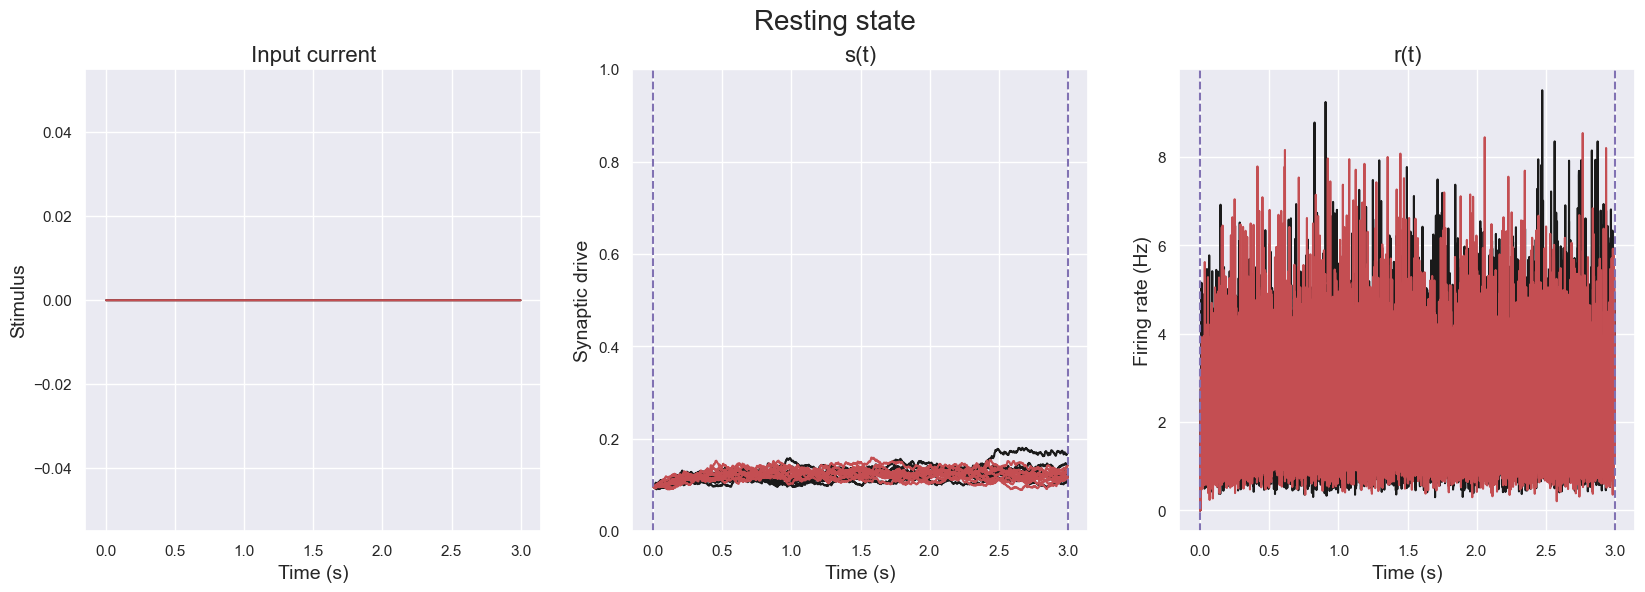

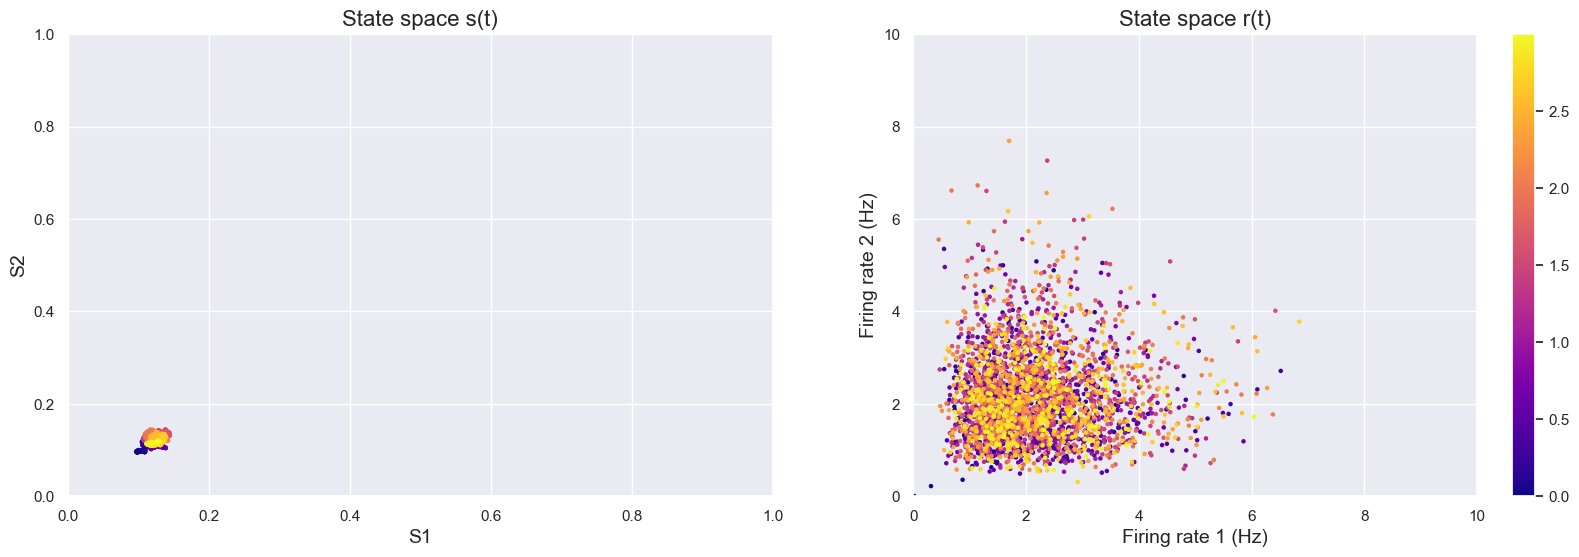

In [4]:
mu = np.zeros((2, params['len_T']))
t_stim = [[0, params['len_T']]]
s,r = synaptic_dynamics(mu, params)

plot_fr_dynamics(r, s, mu, t_stim, '1a', params, fdict)

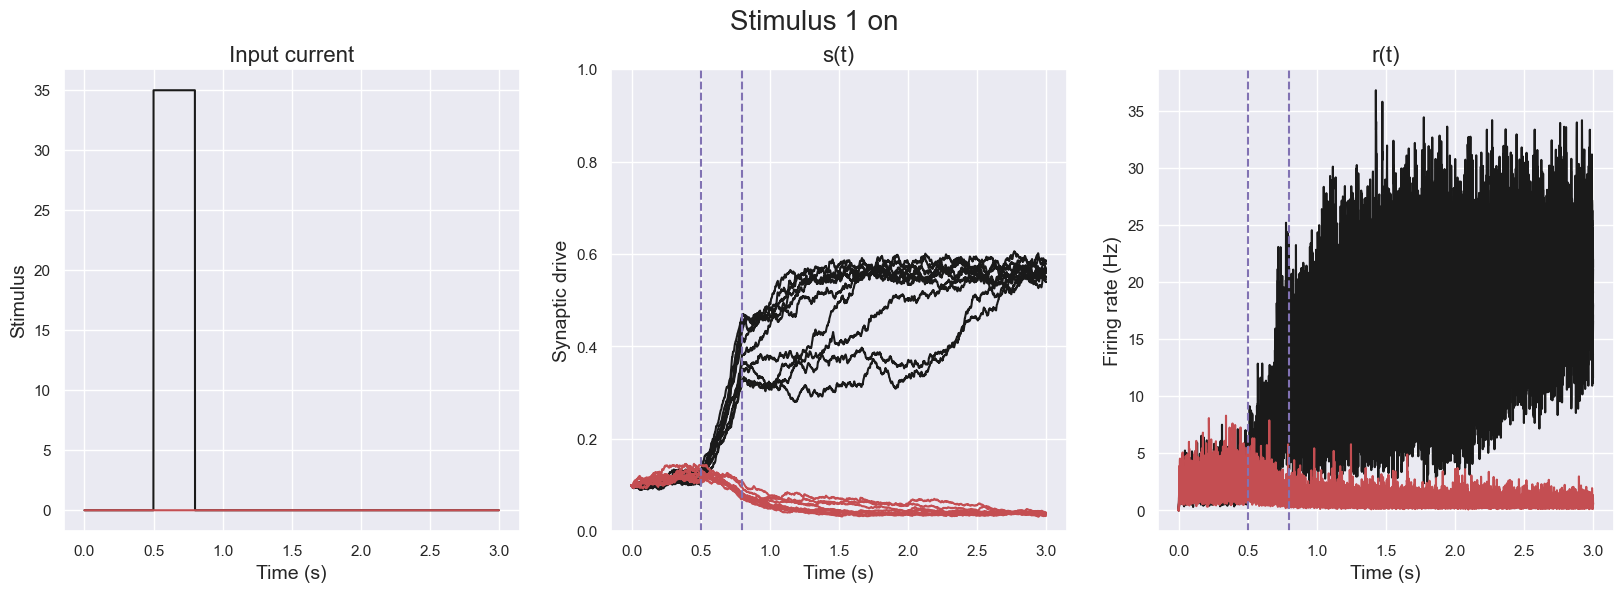

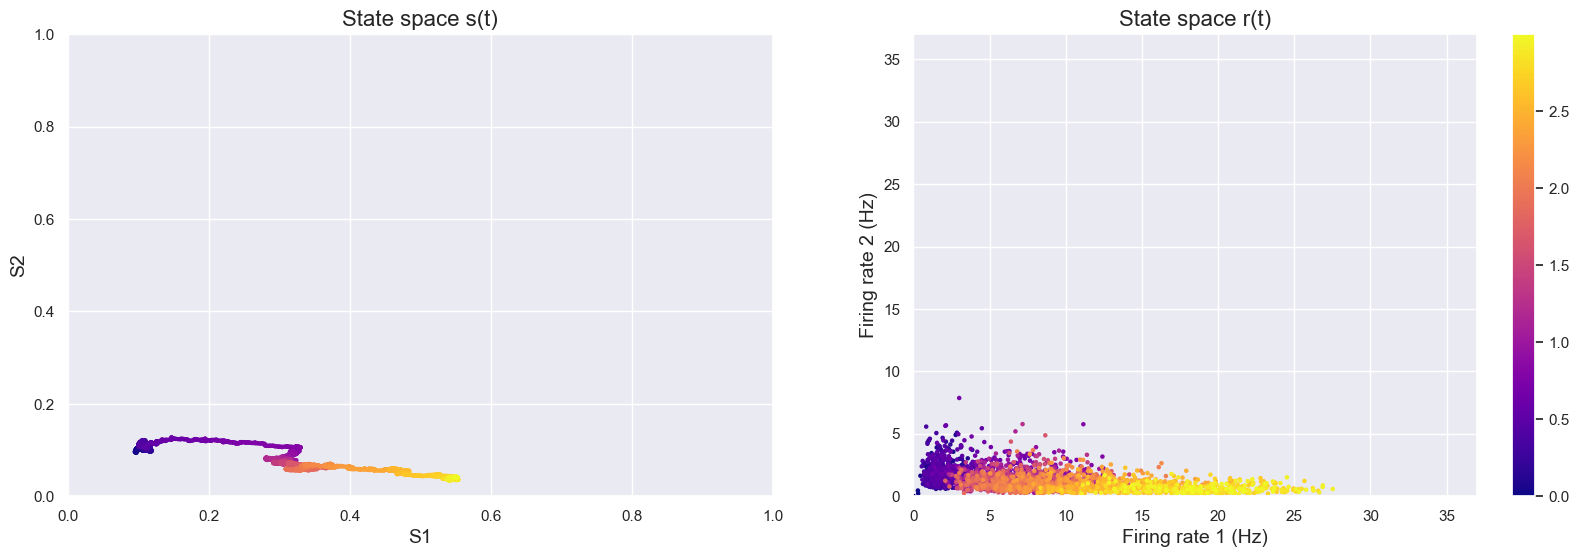

In [5]:
mu = np.zeros((2, params['len_T']))
t_stim = [[500, 800]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 35
s,r = synaptic_dynamics(mu, params)
plot_fr_dynamics(r, s, mu, t_stim, '1b1', params, fdict)

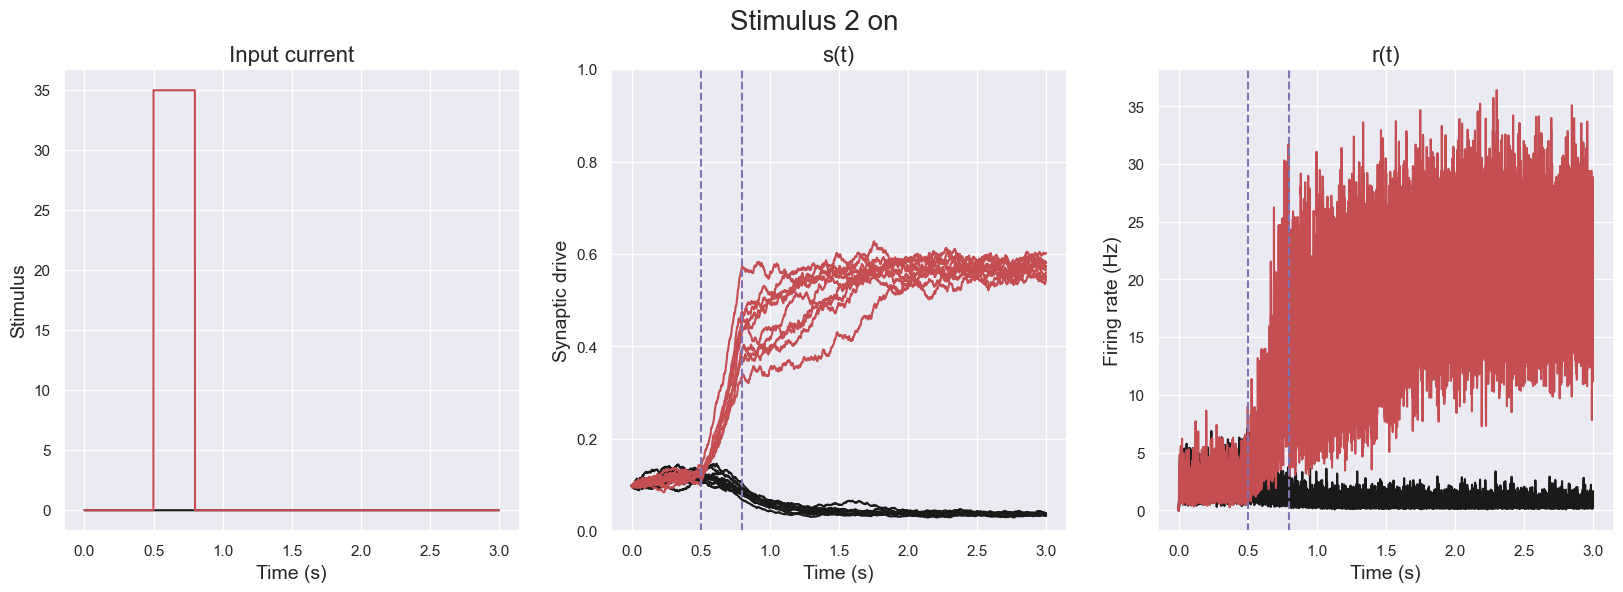

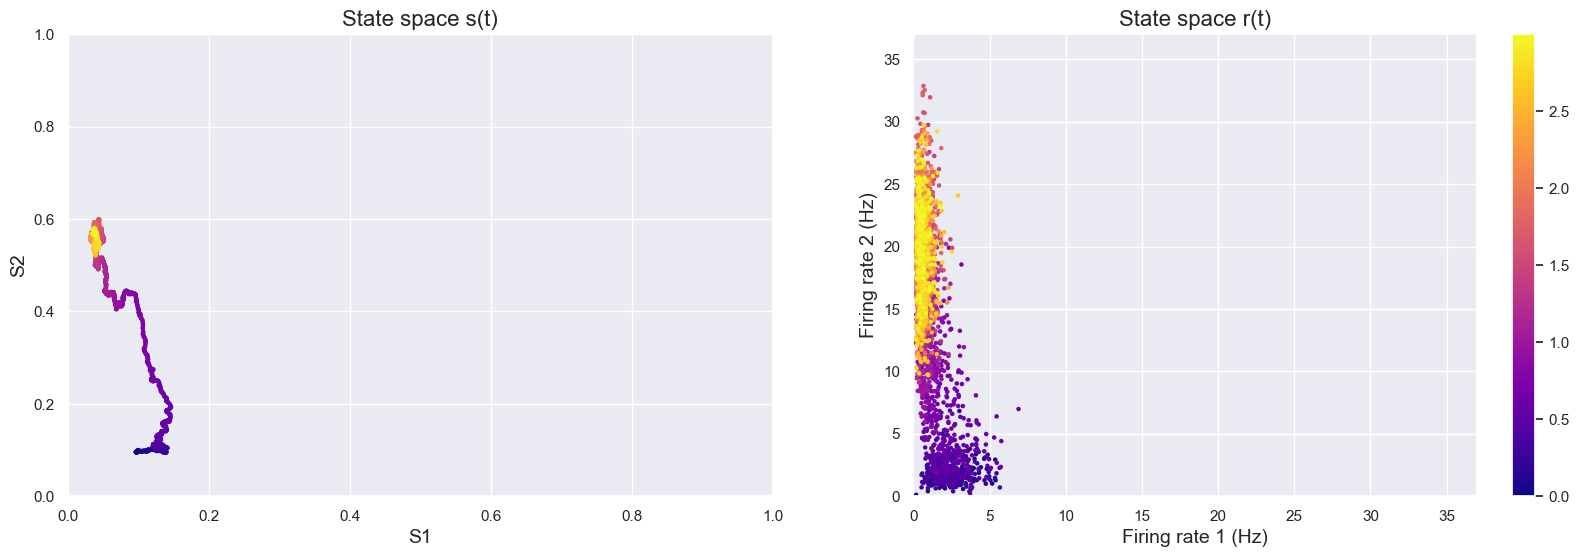

In [6]:
mu = np.zeros((2, params['len_T']))
t_stim = [[500, 800]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[1, tt] = 35
s,r = synaptic_dynamics(mu, params)
plot_fr_dynamics(r, s, mu, t_stim, '1b2', params, fdict)

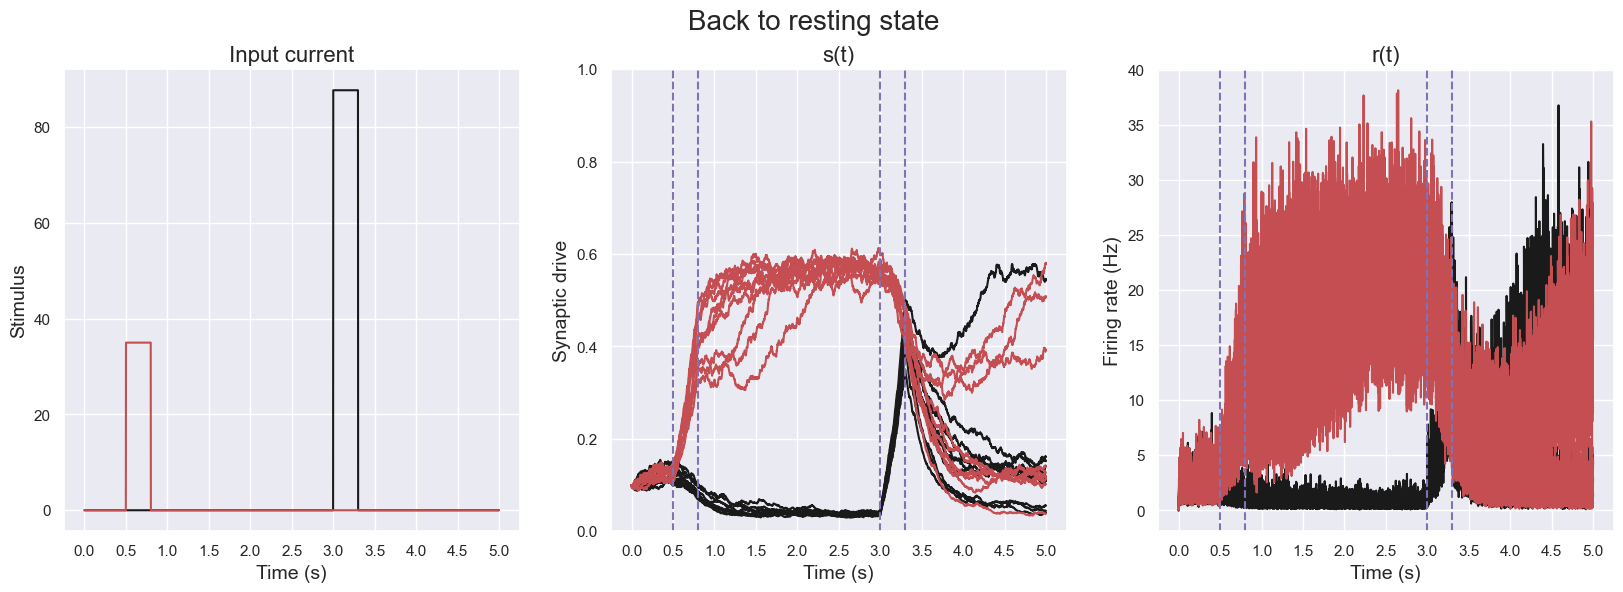

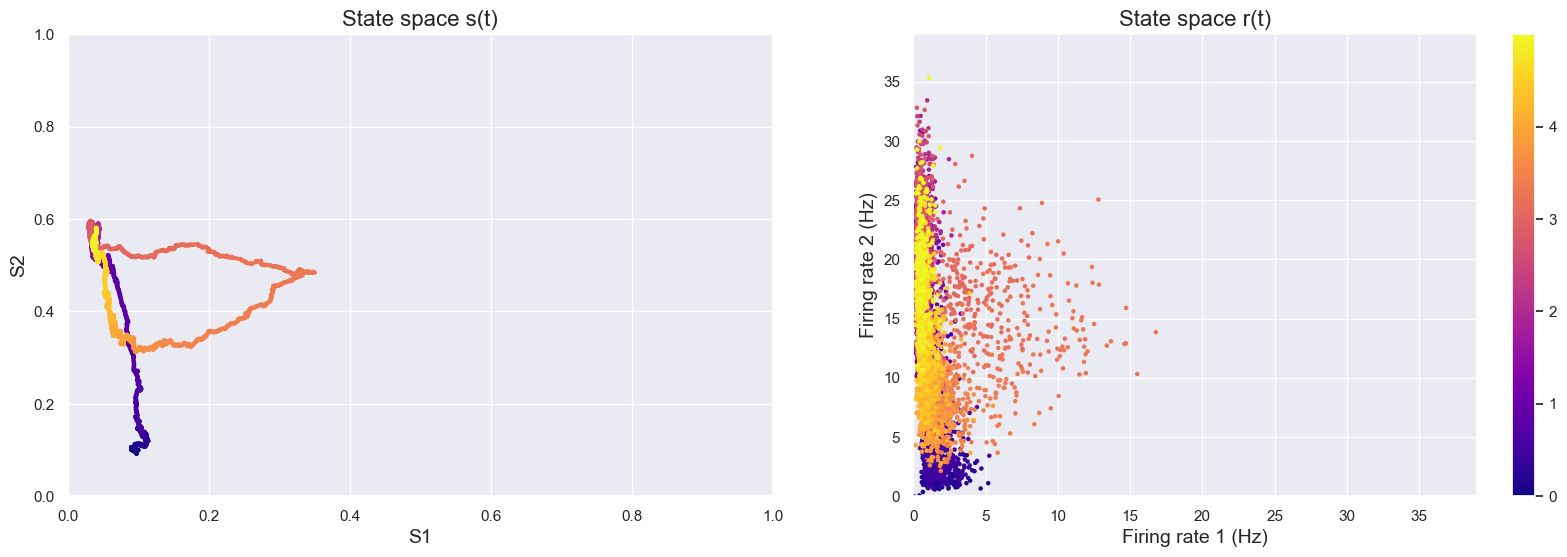

In [7]:
params['Tmax'] = 5
params['len_T'] = int(params['Tmax']/params['del_t'])
mu = np.zeros((2, params['len_T']))

t_stim = [[500, 800], [3000, 3300]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[1, tt] = 35
for tt in range(t_stim[1][0], t_stim[1][1]):
    mu[0, tt] = 87.7
s,r = synaptic_dynamics(mu, params)
plot_fr_dynamics(r, s, mu, t_stim, '1b3', params, fdict)

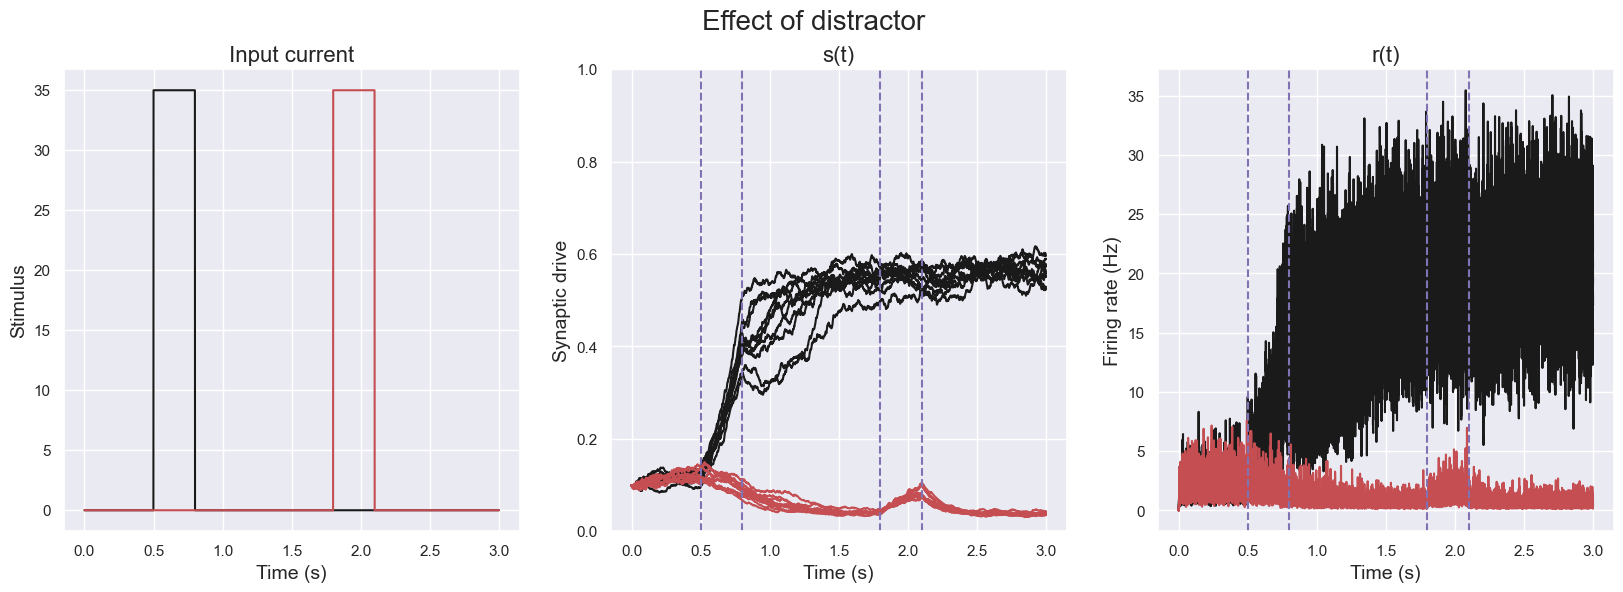

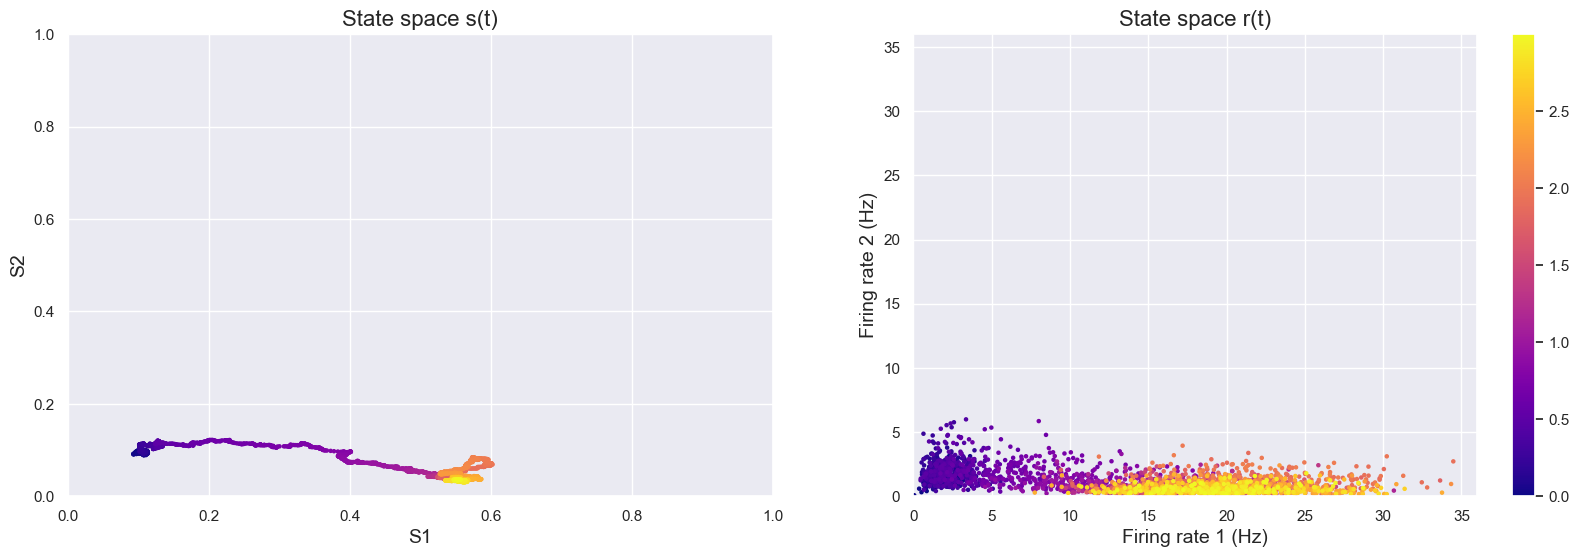

In [8]:
params['Tmax'] = 3
params['len_T'] = int(params['Tmax']/params['del_t'])
mu = np.zeros((2, params['len_T']))

t_stim = [[500, 800],[1800, 2100]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 35
for tt in range(t_stim[1][0], t_stim[1][1]):
    mu[1, tt] = 35
s,r = synaptic_dynamics(mu, params)
plot_fr_dynamics(r, s, mu, t_stim, '1d', params, fdict)

In [ ]:
for blurb in range(10):
    params['gE'] -= 0.001
    mu = np.zeros((2, params['len_T']))
    t_stim = [[500, 800]]
    for tt in range(t_stim[0][0], t_stim[0][1]):
        mu[1, tt] = 35
    s,r = synaptic_dynamics(mu, params)
    plot_fr_dynamics(r, s, mu, t_stim, '1e', params, fdict)

#### Q2. 'Coin-tossing' simulations with $\mu_1 = \mu_2 = \mu_0 - 30 (c^{'} = 0) $. In a decision-making simulation, both $\mu_1 $ and $\mu_2 $ are presented for a time interval, say from $t_1 = 500 $ ms to $t_2 = 1500 $ ms ($T = t_2 - t_1 = 1 sec $), and your total simulation time should be much longer (say 3 sec). The decision choice is determined according to which of the two active attractors wins the competition. In different (n) trials (each with a different seed for the random number generator, but always with the same initial condition $s_1 = s_2 = 0.1$), what do you observe? Do you see 50-50 decision outcome if n is large, say n = 100-500?

Number of trials for which choice is 1 is 7
Number of trials for which choice is 2 is 3


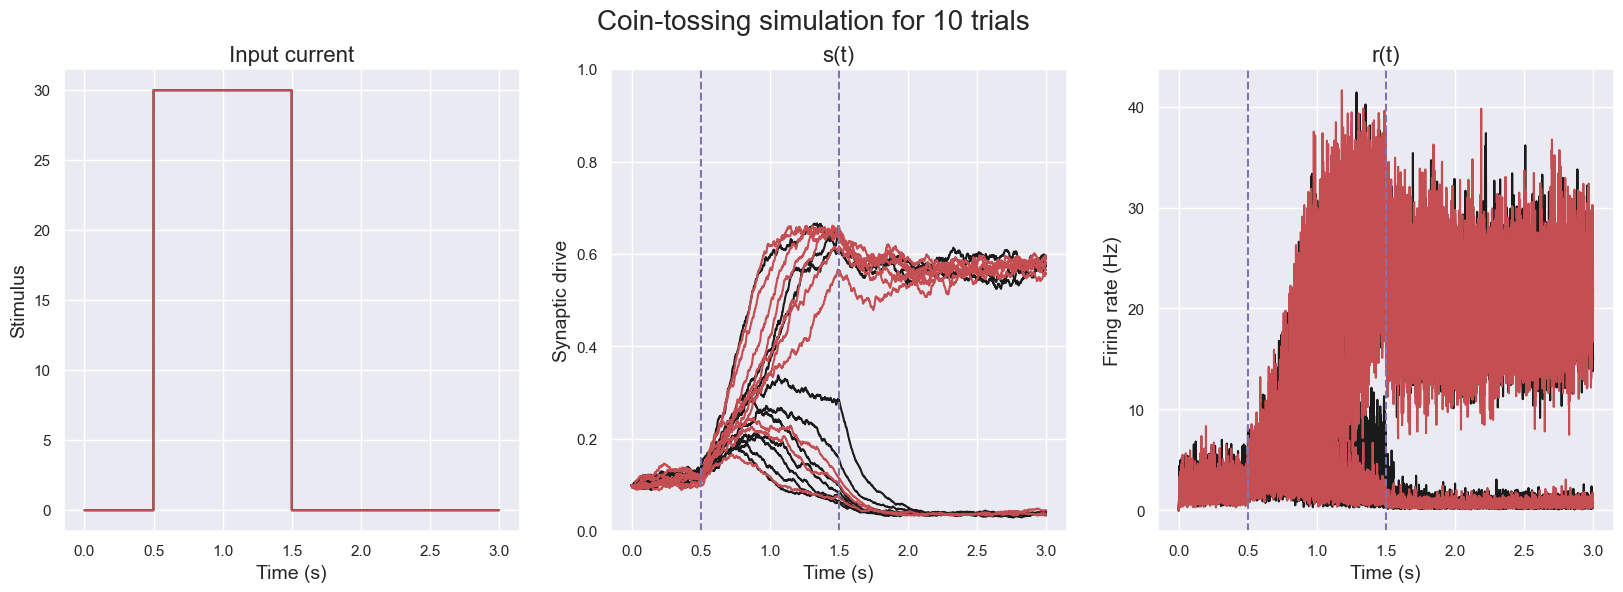

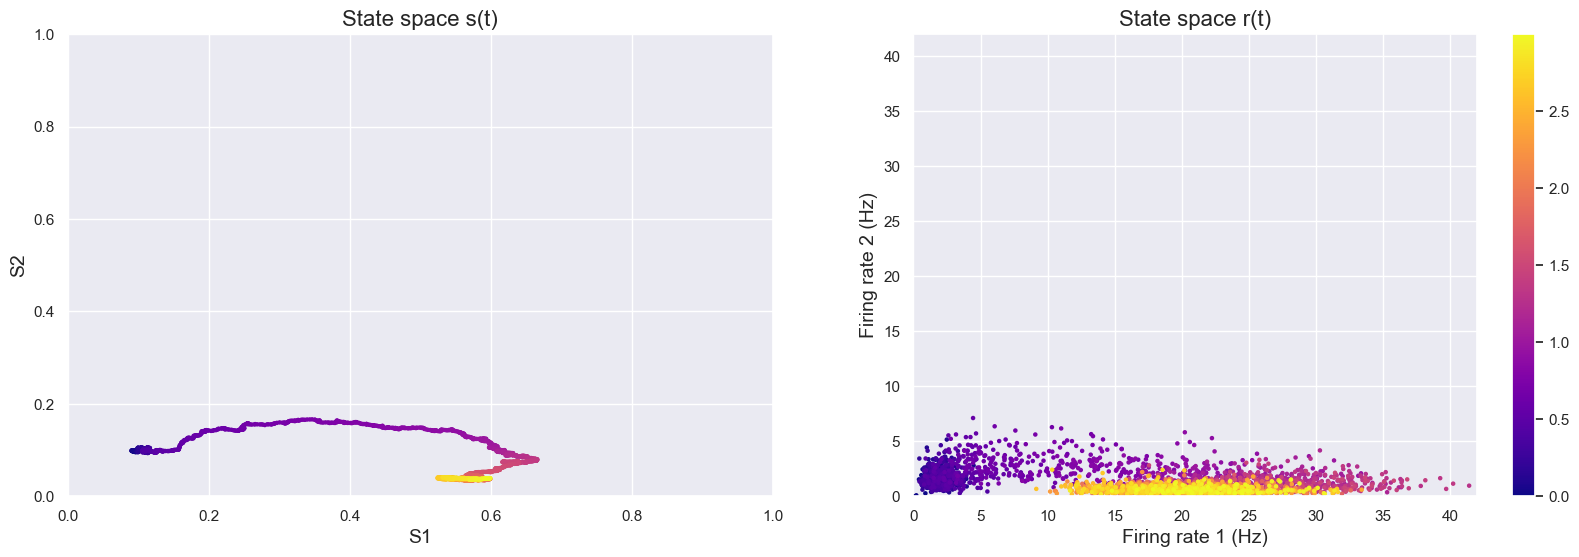

In [18]:
params = reset_params()
mu = np.zeros((2, params['len_T']))
t_stim = [[500, 1500]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 30
    mu[1, tt] = 30
s,r = synaptic_dynamics(mu, params)
choice = np.zeros((params['ntrials'],), dtype = 'int')
for trial in range(params['ntrials']):
    if r[0, -2, trial] < r[1, -2, trial]:
        choice[trial] = 1
    elif r[0, -2, trial] > r[1, -2, trial]:
        choice[trial] = 2
print(f'Number of trials for which choice is 1 is {np.sum(choice == 1)}')
print(f'Number of trials for which choice is 2 is {np.sum(choice == 2)}')
plot_fr_dynamics(r, s, mu, t_stim, '2', params, fdict)

In [19]:
params = reset_params()
params['ntrials'] = 500
mu = np.zeros((2, params['len_T']))
t_stim = [[500, 1500]]
for tt in range(t_stim[0][0], t_stim[0][1]):
    mu[0, tt] = 30
    mu[1, tt] = 30
s,r = synaptic_dynamics(mu, params)
choice = np.zeros((params['ntrials'],), dtype = 'int')
for trial in range(params['ntrials']):
    if r[0, -2, trial] < r[1, -2, trial]:
        choice[trial] = 1
    elif r[0, -2, trial] > r[1, -2, trial]:
        choice[trial] = 2
print(f'Number of trials for which choice is 1 is {np.sum(choice == 1)}')
print(f'Number of trials for which choice is 2 is {np.sum(choice == 2)}')

Number of trials for which choice is 1 is 243
Number of trials for which choice is 2 is 257
